In [2]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


## Données temportelles : Unemployement 

In [12]:

# https://www.kaggle.com/jayrav13/unemployment-by-county-us/data#output.csv
# Taux de chomage tout les mois de 1990 à 2016 tout les mois pour chaque County (compté) des States
unemployment = pd.read_csv(
    os.path.join('data', 'unemployment.csv')
)
print(unemployment.shape)
# recuperation des states de nos airports
#STATE_FULL = airports.STATE_FULL.unique()
#print(STATE_FULL)

# On ne garde que les States des airports du strating kit 
#unemployment = unemployment[unemployment['State'].isin(STATE_FULL)]
#sate_un = unemployment[unemployment['State'].isin(STATE_FULL)].State.unique()
#print("Il nous manque les états de : ",np.setdiff1d(STATE_FULL, sate_un))

# La floride est voisine de la Géorigie et de l'Alabama, la Georgie etant aussi manquante
# nous allons remplacer Floride par Alabama qui ont des taux de chomage comparable depuis 1990. 
#https://www.google.com/publicdata/explore?ds=z1ebjpgk2654c1_&met_y=unemployment_rate&fdim_y=seasonality:S&idim=state:ST1200000000000:ST0600000000000&hl=en&dl=en#!ctype=l&strail=false&bcs=d&nselm=h&met_y=unemployment_rate&fdim_y=seasonality:S&scale_y=lin&ind_y=false&rdim=state&idim=state:ST1200000000000:ST0100000000000&ifdim=state:country:US&hl=en_US&dl=en&ind=false
unemployment_florida = unemployment[unemployment['State'] == 'Alabama']
unemployment_florida['State'] = 'Florida'

# De meme pour la georgie qui est voisine avec : North Carolina, Alabama, South Carolina, Tennessee
# https://www.google.com/publicdata/explore?ds=z1ebjpgk2654c1_&met_y=unemployment_rate&fdim_y=seasonality:S&idim=state:ST1200000000000:ST0600000000000&hl=en&dl=en#!ctype=l&strail=false&bcs=d&nselm=h&met_y=unemployment_rate&fdim_y=seasonality:S&scale_y=lin&ind_y=false&rdim=state&idim=state:ST0100000000000:ST1300000000000:ST4500000000000:ST4700000000000:ST3700000000000&ifdim=state:country:US&hl=en_US&dl=en&ind=false
unemployment_georgia = unemployment[unemployment['State'].isin(['North Carolina','Alabama','South Carolina', 'Tennessee',])]
unemployment_georgia['State'] = 'Georgia'
unemployment_georgia
unemployment = pd.concat([unemployment,unemployment_georgia, unemployment_florida])

# on ne garde que les état qui nous interessent 
unemployment = unemployment[unemployment['State'].isin(STATE_FULL)]



(885548, 5)


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NameError: name 'STATE_FULL' is not defined

In [6]:

# Nous allons calculer la moyenne des County pour garder une granularité par état
state_unemployment = unemployment.groupby(['Year','State','Month']).mean().reset_index()
def monthToNum(shortMonth):
    return{
            'January' : 1,
            'February' : 2,
            'March' : 3,
            'April' : 4,
            'May' : 5,
            'June' : 6,
            'July' : 7,
            'August' : 8,
            'September' : 9, 
            'October' : 10,
            'November' : 11,
            'December' : 12
    }[shortMonth]
state_unemployment['Month'] = state_unemployment['Month'].apply(lambda month : monthToNum(month))
print('On retrouve bien nos 16 états : ', state_unemployment.State.nunique())


On retrouve bien nos 16 états :  47


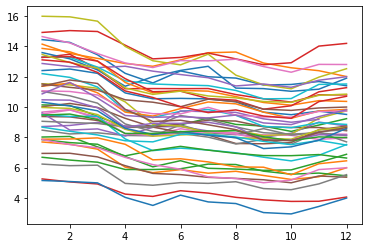

In [7]:

# Unemployement par mois pour chaques state pour l'année 2010 
for state in state_unemployment['State'].unique():
    plot_state_unemployment = state_unemployment[(state_unemployment['State'] == state) & (state_unemployment['Year'] == 2010)][['Month', 'Rate']].sort_values(by="Month")
    plt.plot(plot_state_unemployment.Month, plot_state_unemployment.Rate)
plt.show()


In [8]:

# Le but ici est de créer une date à partir de month et year
#state_unemployment['unemployement_date'] = state_unemployment['Year'].astype('str') +'-'+state_unemployment['Month'].astype('str')
state_unemployment['unemployement_date'] = pd.to_datetime((state_unemployment.Year*10000+state_unemployment.Month*100+ 1).apply(str),format='%Y%m%d')
state_unemployment
state_unemployment.head()


,Year,State,Month,Rate,unemployement_date
0,1990,Alabama,4,7.488060,1990-04-01
1,1990,Alabama,8,8.516418,1990-08-01
2,1990,Alabama,12,8.313433,1990-12-01
3,1990,Alabama,2,8.971642,1990-02-01
4,1990,Alabama,1,8.692537,1990-01-01


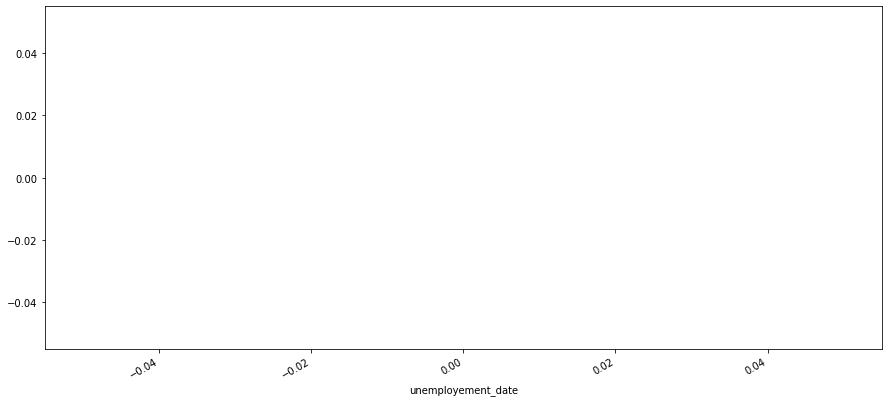

In [10]:

plt.figure(figsize=(15,7))
state_unemployment[(state_unemployment['State'] == 'Georgia')].set_index('unemployement_date')['Rate'].plot()



In [ ]:
IATA_STATE = airports[airports.STATE_FULL.isin(airports.STATE_FULL.unique())][['IATA','STATE_FULL']].rename(columns={'STATE_FULL':'State'})
iata_date = IATA_STATE.merge(state_unemployment[['State', 'Rate', 'unemployement_date']].rename(columns={'unemployement_date':'Date', 'Rate': 'unemployement_rate'}))

# verif : Il y a des mois pour lequel on a pas d'info (pour un état donné)
print("Il nous manque les états de : ",np.setdiff1d(STATE_FULL, iata_date[iata_date['Date'] == "2010-04-01"].State.unique()))
print("Il nous manque les états de : ",np.setdiff1d(STATE_FULL, iata_date[iata_date['Date'] == "2010-05-01"].State.unique()))
iata_date[iata_date.State == 'California']
iata_date[iata_date.State == 'Texas'].Date.unique()
iata_date[iata_date['Date'] == "2010-04-01"].State.unique()
iata_date.set_index('Date')[['IATA', 'unemployement_rate']]
#pd.pivot_table(iata_date[['State', 'unemployement_rate']],values=['State'])
iata_date



## Données temportelles  : Brent - WTI 


FileNotFoundError: [Errno 2] File ../data/brent-monthly_csv.csv does not exist: '../data/brent-monthly_csv.csv'